# Getting Started

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw2_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


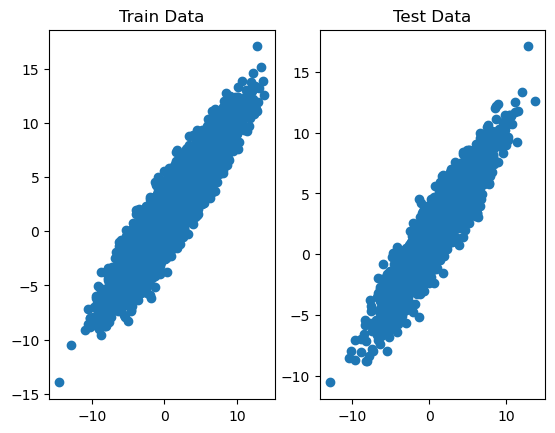

Dataset 2


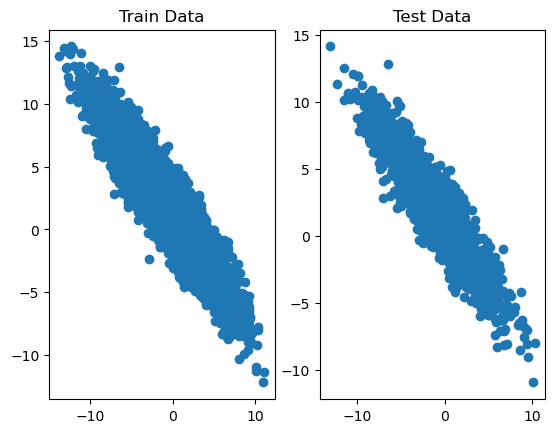

In [4]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.distributions as dist

from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from homeworks.hw2.vae import VAE

In [6]:
def compute_loss(x, mu_x, logvar_x, mu_z, logvar_z):
    # Reconstruction loss (negative log likelihood)
    std_x = torch.exp(0.5 * logvar_x)
    dist_x = dist.Normal(mu_x, std_x)
    recon_loss = -dist_x.log_prob(x).sum(dim=1).mean()

    # The KL divergence for two normal distributions q(z|x) ~ N(μ_z, σ_z^2) and p(z) ~ N(0, 1) has a closed-form formula:
    #
    # D_KL(q(z|x) || p(z)) = - 1/2 * ∑ (1 + log(σ_z^2) - μ_z^2 - σ_z^2)
    #
    # where:
    # - q(z|x) is the learned distribution with mean μ_z and variance σ_z^2.
    # - p(z) is the standard normal prior with mean 0 and variance 1.

    kl_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp(), dim=1).mean()
    
    # Total loss (negative ELBO)
    total_loss = recon_loss + kl_loss
    
    return total_loss, recon_loss, kl_loss

In [7]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, unit='batch')

    for batch_idx, (x,) in enumerate(pbar):
        x = x.to(device)
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_z, logvar_z = model(x)
        loss, recon, kl = compute_loss(x, mu_x, logvar_x, mu_z, logvar_z)
        
        loss.backward()
        optimizer.step()
        
        # Record training metrics
        train_losses.append([loss.item(), recon.item(), kl.item()])
        pbar.set_description(desc=f"batch_loss={loss.item():.4f}")

    return train_losses

In [8]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    with torch.no_grad():
        for x in dataloader:
            x = x[0].to(device)
            mu_x, logvar_x, mu_z, logvar_z = model(x)
            loss, recon, kl = compute_loss(x, mu_x, logvar_x, mu_z, logvar_z)
            
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
    
    return (total_loss / len(dataloader), 
            total_recon / len(dataloader), 
            total_kl / len(dataloader))

In [9]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")

    print(f"Using device: {device}")

    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': False} if torch.cuda.is_available() else \
             {'num_workers': 0} if torch.backends.mps.is_available() else \
             {}

    # Hyperparameters
    batch_size = 128
    hidden_dim = 32
    latent_dim = 2
    lr = 1e-3
    n_epochs = 10
    
    # Convert data to PyTorch tensors
    train_tensor = torch.FloatTensor(train_data).to(device)
    test_tensor = torch.FloatTensor(test_data).to(device)
    
    # Create dataloaders
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = VAE(input_dim=2, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize arrays to store metrics
    train_curves = []
    epoch_curves = []
    
    # Evaluate initial performance
    init_test_loss = evaluate_model(model, test_loader, device)
    epoch_curves.append(init_test_loss)
    
    # Training loop
    for epoch in range(n_epochs):
        train_metrics = train_epoch(model, train_loader, optimizer, device)
        train_curves.extend(train_metrics)
        
        # Evaluate on test set after each epoch
        test_metrics = evaluate_model(model, test_loader, device)
        epoch_curves.append(test_metrics)
    
        print(f'Epoch {epoch+1}/{n_epochs}, Test Loss: {test_metrics[0]:.4f}')
    
    # Generate samples
    samples_with_noise = model.sample(1000, device, with_noise=True)
    samples_without_noise = model.sample(1000, device, with_noise=False)
    
    return (np.array(train_curves),
            np.array(epoch_curves),
            samples_with_noise,
            samples_without_noise)


### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Using device: mps


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 1/10, Test Loss: 7.0576


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 2/10, Test Loss: 5.4614


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3/10, Test Loss: 5.3799


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4/10, Test Loss: 5.3468


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5/10, Test Loss: 5.2788


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 6/10, Test Loss: 5.1772


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7/10, Test Loss: 4.8891


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 8/10, Test Loss: 4.6391


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 9/10, Test Loss: 4.5072


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 10/10, Test Loss: 4.4515
Final -ELBO: 4.4515, Recon Loss: 2.8913, KL Loss: 1.5602


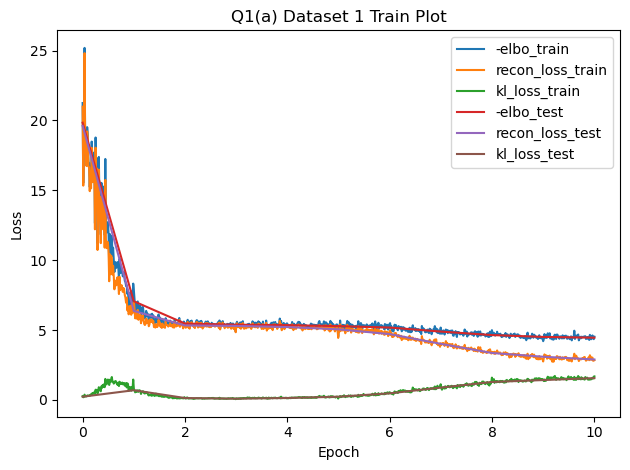

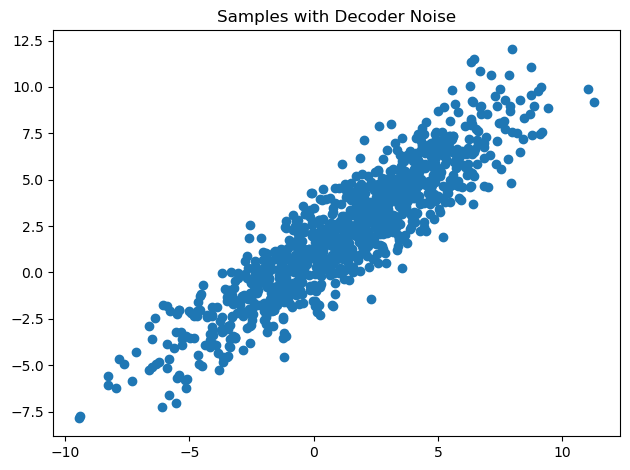

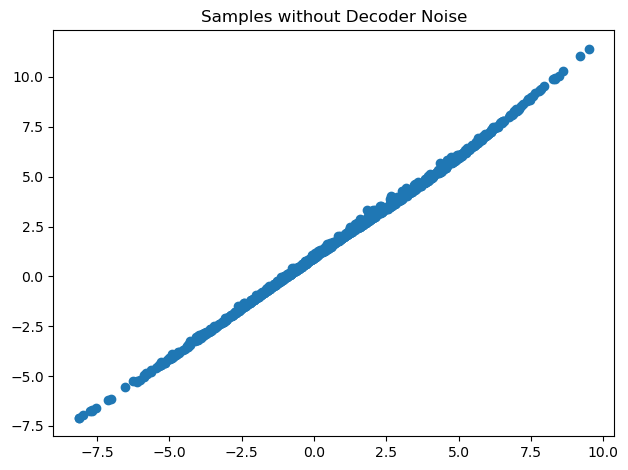

In [10]:
q1_save_results('a', 1, q1)

Using device: mps


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 1/10, Test Loss: 7.1824


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 2/10, Test Loss: 5.4225


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3/10, Test Loss: 5.3769


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4/10, Test Loss: 5.3687


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5/10, Test Loss: 5.3454


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 6/10, Test Loss: 5.3288


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7/10, Test Loss: 5.3326


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 8/10, Test Loss: 5.3095


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 9/10, Test Loss: 5.3111


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 10/10, Test Loss: 5.2853
Final -ELBO: 5.2853, Recon Loss: 4.9740, KL Loss: 0.3113


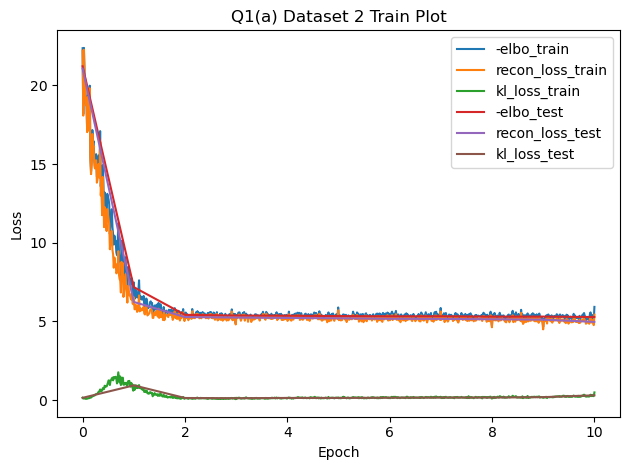

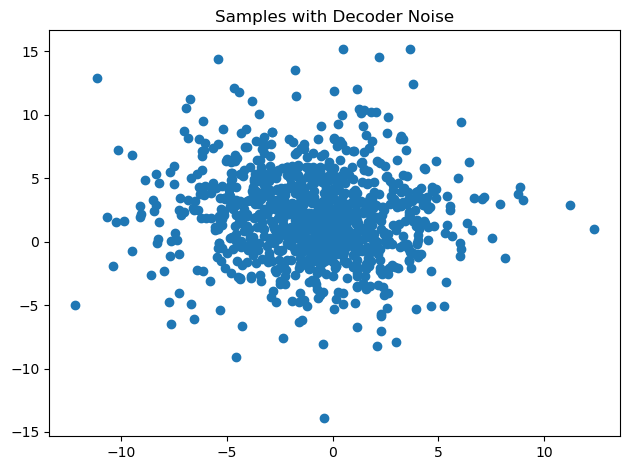

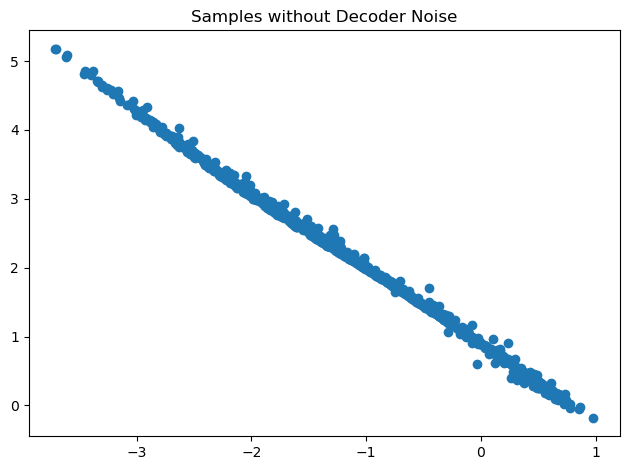

In [11]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


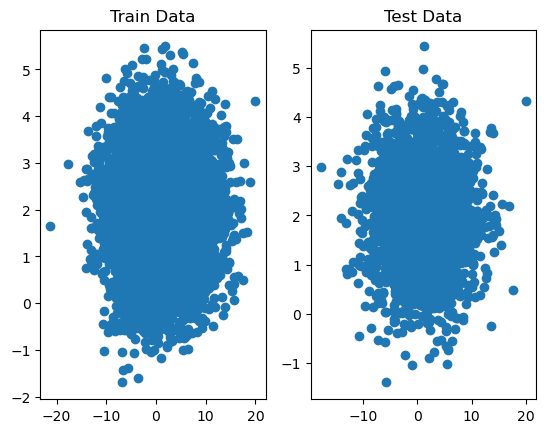

Dataset 2


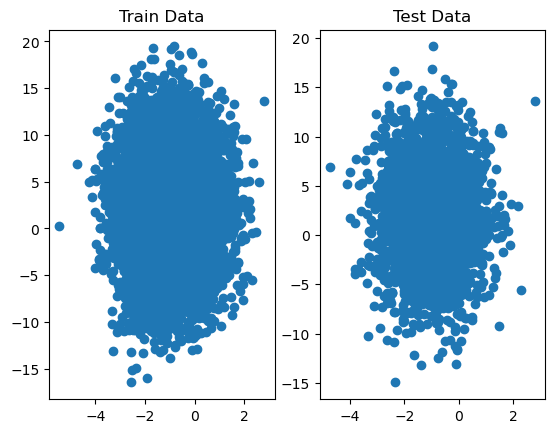

In [12]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Using device: mps


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 1/10, Test Loss: 7.4151


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 2/10, Test Loss: 4.6748


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3/10, Test Loss: 4.5005


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4/10, Test Loss: 4.4506


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5/10, Test Loss: 4.4351


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 6/10, Test Loss: 4.4338


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7/10, Test Loss: 4.4351


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 8/10, Test Loss: 4.4299


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 9/10, Test Loss: 4.4305


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 10/10, Test Loss: 4.4281
Final -ELBO: 4.4281, Recon Loss: 4.4053, KL Loss: 0.0228


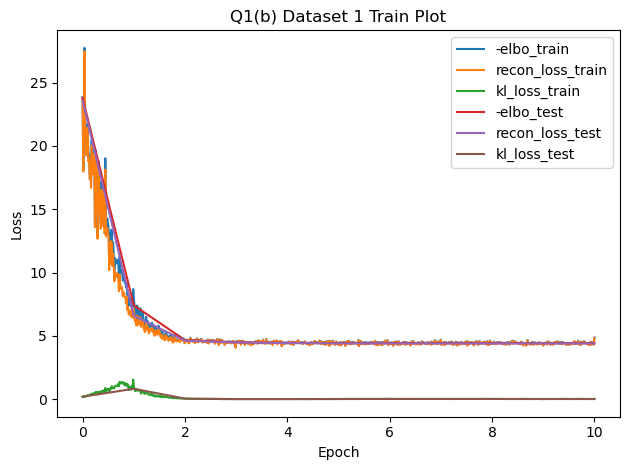

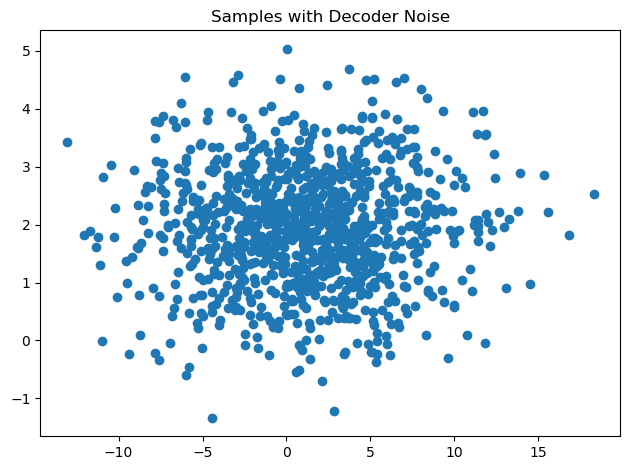

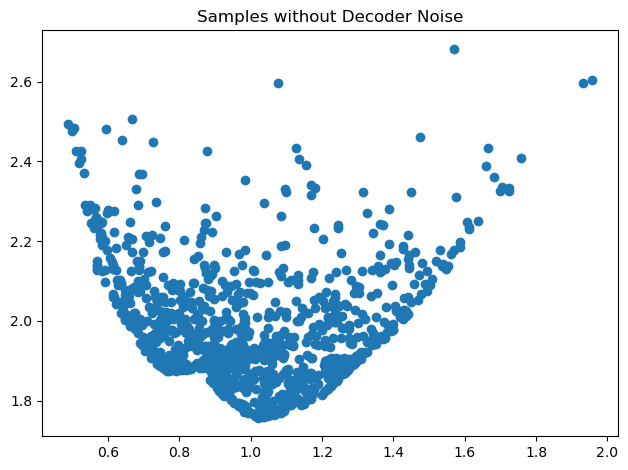

In [13]:
q1_save_results('b', 1, q1)

Using device: mps


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 1/10, Test Loss: 5.2500


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 2/10, Test Loss: 4.4837


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3/10, Test Loss: 4.4516


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4/10, Test Loss: 4.4451


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5/10, Test Loss: 4.4333


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 6/10, Test Loss: 4.4448


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7/10, Test Loss: 4.4384


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 8/10, Test Loss: 4.4353


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 9/10, Test Loss: 4.4246


  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 10/10, Test Loss: 4.4346
Final -ELBO: 4.4346, Recon Loss: 4.4190, KL Loss: 0.0157


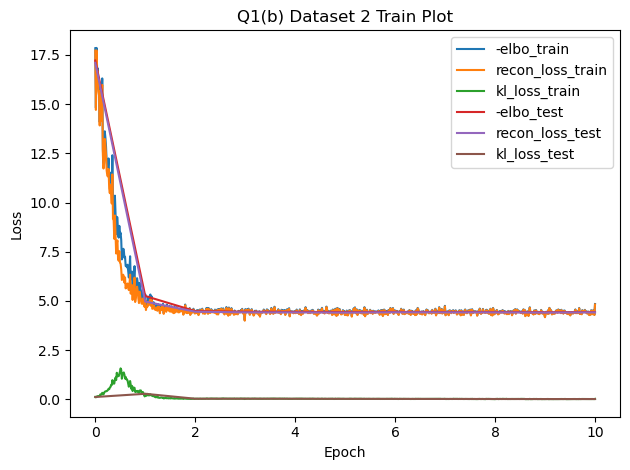

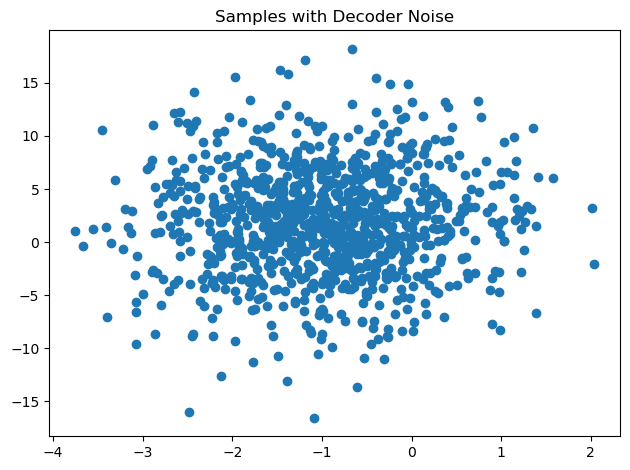

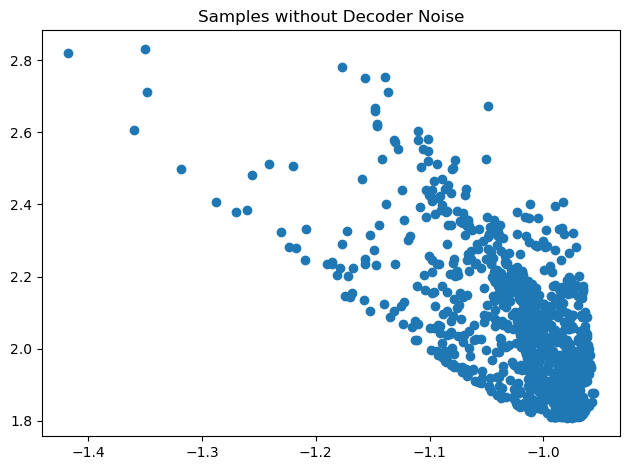

In [14]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

The latent variables are not being used in dataset a. This is because when q(z|x) ≈ p(z), meaning the encoder is outputting something very close to the prior, the KL term KL(q(z|x)||p(z)) becomes very small. The decoder essentially learns to ignore the latent variables and acts as a simple autoencoder. It is called "posterior collapse"


**Why It Happens**


- If the decoder is too powerful (e.g., with high capacity neural networks), it can learn to reconstruct the data without using the latent variables

- The model can minimize the ELBO by:
    - Making q(z|x) match p(z) perfectly (minimizing KL term)
    - Having the decoder ignore z and still reconstruct x well

- This is especially likely when:
    - The data is simple and can be modeled without latent variables
    - The decoder network is more powerful than necessary
    - The KL weight in the loss function is too high relative to the reconstruction term